<a href="https://colab.research.google.com/github/CPernet/OpenNeuro_MetaPrivAssessment/blob/main/Correlation_Analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [2]:
# Import Libraries
!git clone https://github.com/CPernet/OpenNeuro_MetaPrivAssessment.git

import sys
sys.path.append("..")
import os
os.chdir('OpenNeuro_MetaPrivAssessment') # Change directory to the cloned repository

fatal: destination path 'OpenNeuro_MetaPrivAssessment' already exists and is not an empty directory.


In [3]:
import pandas as pd
from scipy.stats import spearmanr
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

## Extracting PIF & SUDA score across all datasets for rows.

In [4]:
def collect_scores(base_dir, input_word, score_field, pif_index_col='Unnamed: 0'):
    all_data = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().startswith(input_word) and file.lower().endswith(".csv"):
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(os.path.dirname(file_path))

                try:
                    # Read the file
                    df = pd.read_csv(file_path)

                    if input_word.lower() == 'pif':
                        # For PIF files, use 'Unnamed: 0' as the original index
                        if pif_index_col in df.columns and score_field in df.columns:
                            temp_df = df[[score_field]].copy()
                            temp_df['original_index'] = df[pif_index_col]
                            temp_df['file_name'] = file
                            temp_df['folder_name'] = folder_name
                            all_data.append(temp_df)
                    elif input_word.lower() == 'suda':
                        # For SUDA files, use the DataFrame's default index
                        if score_field in df.columns:
                            temp_df = df[[score_field]].copy()
                            temp_df['original_index'] = df.index
                            temp_df['file_name'] = file
                            temp_df['folder_name'] = folder_name
                            all_data.append(temp_df)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

    if all_data:
        result_df = pd.concat(all_data, ignore_index=True)
        return result_df
    else:
        return pd.DataFrame(columns=[score_field, 'original_index', 'file_name', 'folder_name'])

# Specify the base directory
base_directory = os.getcwd()

# Collect scores for 'suda' datasets
result_suda = collect_scores(base_directory, 'suda', 'dis-score')

# Collect scores for 'pif' datasets
result_pif = collect_scores(base_directory, 'pif', 'RIG')
result_pif = result_pif.sort_values(by=['file_name', 'original_index'], ascending=[True, True])


In [5]:
def collect_scores(base_dir, input_word, score_field, pif_index_col='Unnamed: 0'):
    all_data = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().startswith(input_word) and file.lower().endswith(".csv"):
                file_path = os.path.join(root, file)
                # Get the parent directory of the file
                parent_dir = os.path.dirname(file_path)
                # Get the name of the directory above the parent directory
                folder_name = os.path.basename(os.path.dirname(parent_dir))


                try:
                    # Read the file
                    df = pd.read_csv(file_path)

                    if input_word.lower() == 'pif':
                        # For PIF files, use 'Unnamed: 0' as the original index
                        if pif_index_col in df.columns and score_field in df.columns:
                            temp_df = df[[score_field]].copy()
                            temp_df['original_index'] = df[pif_index_col]
                            temp_df['file_name'] = file
                            temp_df['folder_name'] = folder_name
                            all_data.append(temp_df)
                    elif input_word.lower() == 'suda':
                        # For SUDA files, use the DataFrame's default index
                        if score_field in df.columns:
                            temp_df = df[[score_field]].copy()
                            temp_df['original_index'] = df.index
                            temp_df['file_name'] = file
                            temp_df['folder_name'] = folder_name
                            all_data.append(temp_df)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

    if all_data:
        result_df = pd.concat(all_data, ignore_index=True)
        return result_df
    else:
        return pd.DataFrame(columns=[score_field, 'original_index', 'file_name', 'folder_name'])

# Specify the base directory
base_directory = os.getcwd()

# Collect scores for 'suda' datasets
result_suda = collect_scores(base_directory, 'suda', 'dis-score')

# Collect scores for 'pif' datasets
result_pif = collect_scores(base_directory, 'pif', 'RIG')
result_pif = result_pif.sort_values(by=['file_name', 'original_index'], ascending=[True, True])

Merged DataFrame:
Global Spearman Correlation: 0.7503 [95% CI: 0.7407, 0.7592], P-value: 0.0000
Global Spearman Correlation: 0.7503 [95% CI: 0.7407, 0.7592], P-value: 0.0000


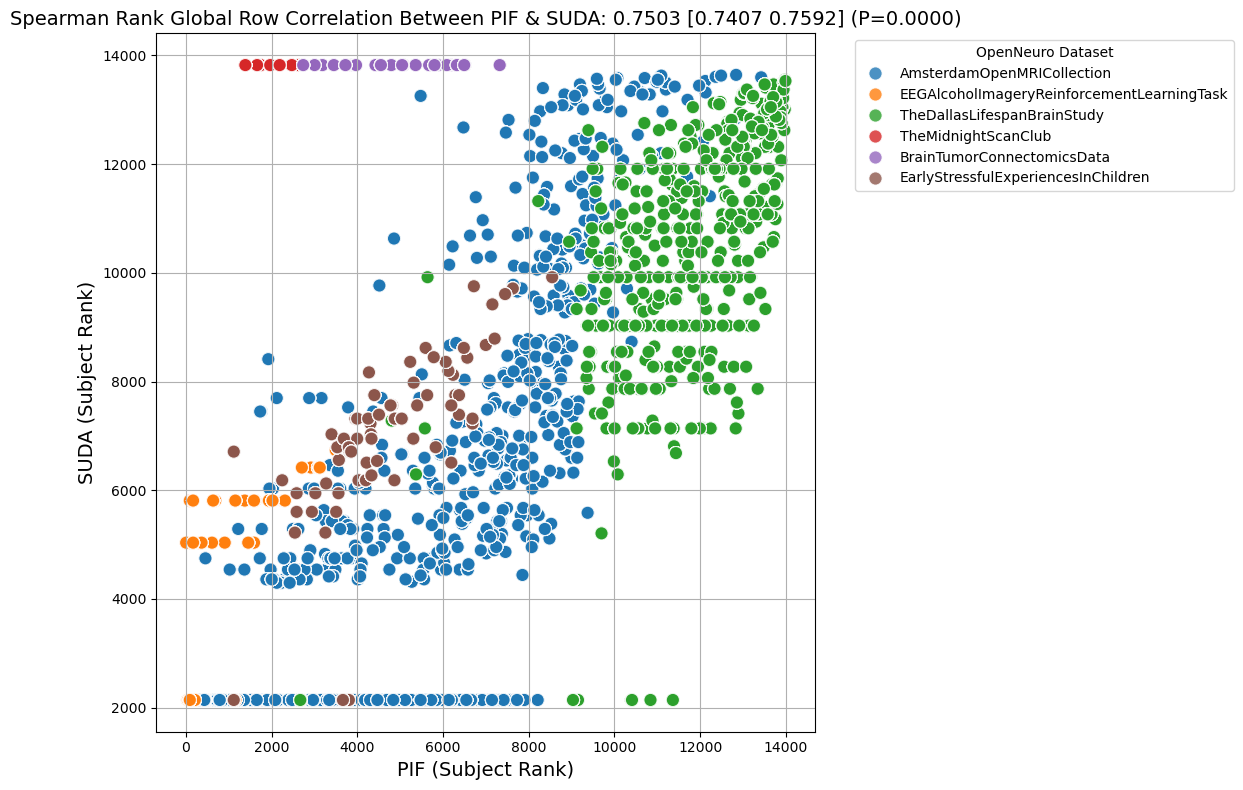

In [6]:
merged = pd.merge(result_pif, result_suda, on=['original_index', 'folder_name'], suffixes=('_pif', '_suda'))
if merged.empty:
    print("The merged DataFrame is empty. Check file names and original index alignment.")
else:
    print("Merged DataFrame:")

    merged['RIG_rank'] = merged['RIG'].rank()
    merged['dis_score_rank'] = merged['dis-score'].rank()
    spearman_corr, p_value = spearmanr(merged['RIG'], merged['dis-score'])

    # Bootstrap 95% CI
    import numpy as np
    np.random.seed(42)
    n_bootstrap = 1000
    bootstrap_corrs = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(merged), size=len(merged), replace=True)
        boot_sample = merged.iloc[indices]
        boot_corr, _ = spearmanr(boot_sample['RIG'], boot_sample['dis-score'])
        bootstrap_corrs.append(boot_corr)
    ci_lower = np.percentile(bootstrap_corrs, 2.5)
    ci_upper = np.percentile(bootstrap_corrs, 97.5)

    print(f"Global Spearman Correlation: {spearman_corr:.4f} [95% CI: {ci_lower:.4f}, {ci_upper:.4f}], P-value: {p_value:.4f}")
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=merged,
        x='RIG_rank',
        y='dis_score_rank',
        hue='folder_name',
        palette='tab10',
        s=90,
        alpha=0.8,
    )

    plt.grid(True)
    plt.title(f"Spearman Rank Global Row Correlation Between PIF & SUDA: {spearman_corr:.4f} [{ci_lower:.4f} {ci_upper:.4f}] (P={p_value:.4f})", fontsize=14)
    plt.xlabel('PIF (Subject Rank)', fontsize=14)
    plt.ylabel('SUDA (Subject Rank)', fontsize=14)
    plt.legend(title='OpenNeuro Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('spearman_rank_correlation_plot.png', dpi=300)
    plt.show()

## Extracting K-Global, SUDA & PIF score across all datasets for fields.

In [7]:
def extract_att_suda_files(base_dir):
    all_data = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower() == 'att_suda.csv':
                file_path = os.path.join(root, file)
                # Get the parent directory of the file
                parent_dir = os.path.dirname(root)
                # Get the name of the directory above the parent directory
                folder_name = os.path.basename(parent_dir)

                try:
                    df = pd.read_csv(file_path)
                    if 'variable' in df.columns and 'contribution' in df.columns:
                        temp_df = df[['variable', 'contribution']].copy()
                        temp_df['folder_name'] = folder_name
                        temp_df['file_name'] = file
                        all_data.append(temp_df)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

    if all_data:
        result_df = pd.concat(all_data, ignore_index=True)
        return result_df
    else:
        return pd.DataFrame(columns=['variable', 'contribution', 'folder_name', 'file_name'])

base_directory = os.getcwd()
result_suda_fields = extract_att_suda_files(base_directory)
print(result_suda_fields)

                variable  contribution                  folder_name  \
0   religious_upbringing         11.46   AmsterdamOpenMRICollection   
1             handedness          7.88   AmsterdamOpenMRICollection   
2                    sex          8.37   AmsterdamOpenMRICollection   
3        education_level         19.11   AmsterdamOpenMRICollection   
4      gender_identity_M         36.11   AmsterdamOpenMRICollection   
..                   ...           ...                          ...   
94               EduComp         21.94  TheDallasLifespanBrainStudy   
95                   Sex          7.80  TheDallasLifespanBrainStudy   
96             Ethnicity          4.26  TheDallasLifespanBrainStudy   
97             Height_W1         44.93  TheDallasLifespanBrainStudy   
98             AgeMRI_W1         78.48  TheDallasLifespanBrainStudy   

       file_name  
0   att_suda.csv  
1   att_suda.csv  
2   att_suda.csv  
3   att_suda.csv  
4   att_suda.csv  
..           ...  
94  att_suda.c

In [8]:
def extract_normalized_files(base_dir):
    all_data = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().startswith('normalized') and file.lower().endswith('.csv'):
                file_path = os.path.join(root, file)
                # Get the parent directory of the file
                parent_dir = os.path.dirname(root)
                # Get the name of the directory above the parent directory
                folder_name = os.path.basename(parent_dir)

                try:
                    df = pd.read_csv(file_path)
                    if 'Column' in df.columns and 'Normalized Difference' in df.columns:
                        temp_df = df[['Column', 'Normalized Difference']].copy()
                        temp_df['folder_name'] = folder_name
                        temp_df['file_name'] = file
                        all_data.append(temp_df)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame(columns=['Column', 'Normalized Difference', 'folder_name', 'file_name'])

base_directory = os.getcwd()
result_k_global = extract_normalized_files(base_directory)
print(result_k_global)

             Column  Normalized Difference                  folder_name  \
0   education_level                   42.7   AmsterdamOpenMRICollection   
1    background_SES                   41.8   AmsterdamOpenMRICollection   
2               sex                   34.0   AmsterdamOpenMRICollection   
3        handedness                   18.5   AmsterdamOpenMRICollection   
4               age                   18.3   AmsterdamOpenMRICollection   
..              ...                    ...                          ...   
88     EduYrsEstCap                    0.0  TheDallasLifespanBrainStudy   
89             Race                    0.0  TheDallasLifespanBrainStudy   
90          EduComp                    0.0  TheDallasLifespanBrainStudy   
91              Sex                    0.0  TheDallasLifespanBrainStudy   
92        Ethnicity                    0.0  TheDallasLifespanBrainStudy   

                            file_name  
0   normalized_difference_results.csv  
1   normalized_diff

In [9]:
def extract_and_sum_pif_files_with_column_names(base_dir):
    all_data = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().startswith('pif') and file.lower().endswith('.csv'):
                file_path = os.path.join(root, file)
                # Get the parent directory of the file
                parent_dir = os.path.dirname(root)
                # Get the name of the directory above the parent directory
                folder_name = os.path.basename(parent_dir)
                try:
                    df = pd.read_csv(file_path)
                    if 'RIG' in df.columns:
                        df = df.drop(columns=['RIG','Unnamed: 0'])
                    sum_scores = df.sum()/len(df)
                    for col_name, col_sum in sum_scores.items():
                        all_data.append({'folder_name': folder_name, 'column_name': col_name, 'sum_score': col_sum})
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")
    return pd.DataFrame(all_data)


base_directory = os.getcwd()
result_pif_fields = extract_and_sum_pif_files_with_column_names(base_directory)
result_suda_fields = result_suda_fields.rename(columns={"variable": "column_name"})
print(result_pif_fields)
print(result_suda_fields)

                     folder_name          column_name  sum_score
0     AmsterdamOpenMRICollection                  age   3.310196
1     AmsterdamOpenMRICollection  sexual_attraction_M   1.594382
2     AmsterdamOpenMRICollection  sexual_attraction_F   1.615016
3     AmsterdamOpenMRICollection    gender_identity_M   1.579839
4     AmsterdamOpenMRICollection    gender_identity_F   1.594679
..                           ...                  ...        ...
121  TheDallasLifespanBrainStudy               BMI_W1   8.006840
122          TheMidnightScanClub                  age   2.521928
123          TheMidnightScanClub      education_years   2.521928
124          TheMidnightScanClub     education_degree   1.970951
125          TheMidnightScanClub               gender   1.000000

[126 rows x 3 columns]
             column_name  contribution                  folder_name  \
0   religious_upbringing         11.46   AmsterdamOpenMRICollection   
1             handedness          7.88   AmsterdamOpen

## Correlation spearman rank K-Global & SUDA


Global Spearman Correlation: 0.2933 [95% CI: 0.1742, 0.4111], P-value: 0.0000


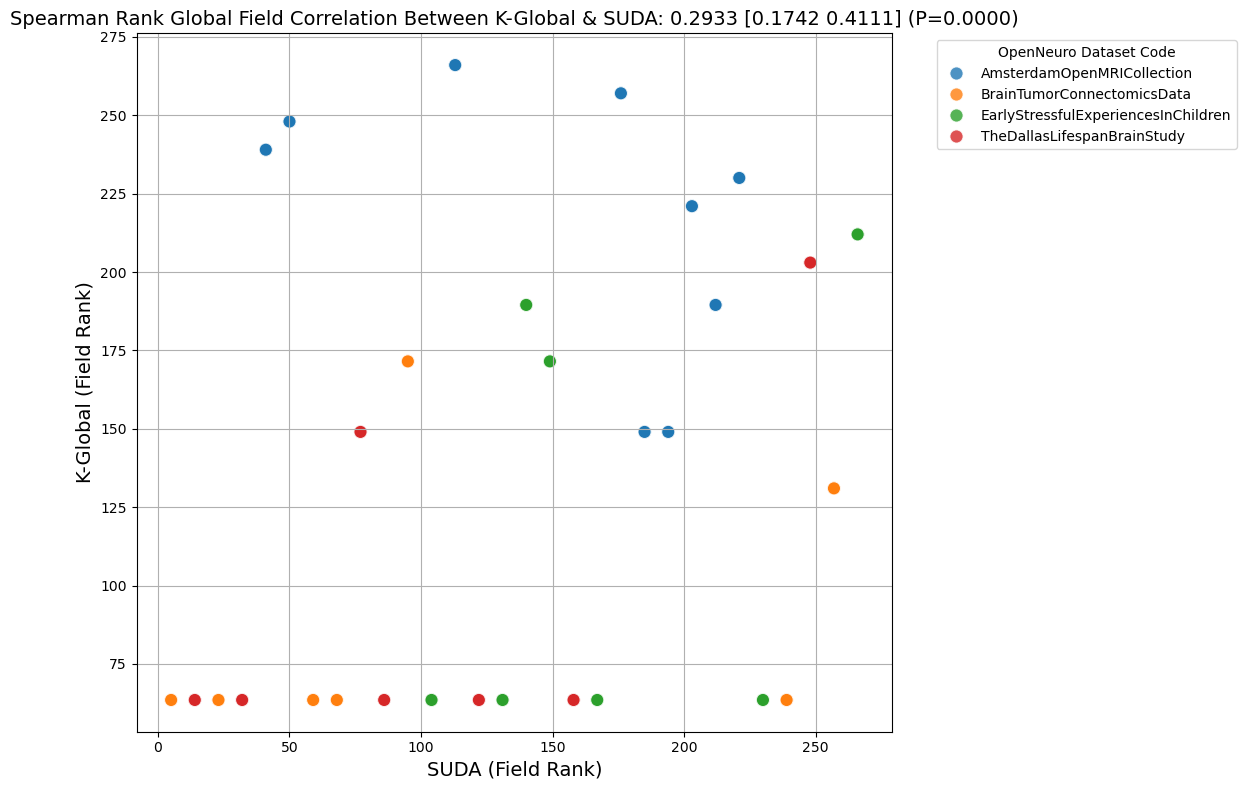

In [10]:
result_k_global = pd.DataFrame(result_k_global)
result_suda = pd.DataFrame(result_suda_fields)
merged = pd.merge(
    result_k_global,
    result_suda,
    left_on=["Column", "folder_name"],
    right_on=["column_name", "folder_name"],

)

merged['folder_name'] = merged['folder_name'].str.replace('data_', '', regex=False)
merged['k_global_rank'] = merged['Normalized Difference'].rank()
merged['suda_field_rank'] = merged['contribution'].rank()
spearman_corr, p_value = spearmanr(merged['Normalized Difference'], merged['contribution'])

# Bootstrap 95% CI
import numpy as np
np.random.seed(42)
n_bootstrap = 1000
bootstrap_corrs = []
for _ in range(n_bootstrap):
    indices = np.random.choice(len(merged), size=len(merged), replace=True)
    boot_sample = merged.iloc[indices]
    boot_corr, _ = spearmanr(boot_sample['Normalized Difference'], boot_sample['contribution'])
    bootstrap_corrs.append(boot_corr)
ci_lower = np.percentile(bootstrap_corrs, 2.5)
ci_upper = np.percentile(bootstrap_corrs, 97.5)

print(f"Global Spearman Correlation: {spearman_corr:.4f} [95% CI: {ci_lower:.4f}, {ci_upper:.4f}], P-value: {p_value:.4f}")
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=merged,
    x='suda_field_rank',
    y='k_global_rank',
    hue='folder_name',
    palette='tab10',
    s=90,
    alpha=0.8
)
plt.grid(True)
plt.title(f"Spearman Rank Global Field Correlation Between K-Global & SUDA: {spearman_corr:.4f} [{ci_lower:.4f} {ci_upper:.4f}] (P={p_value:.4f})", fontsize=14)
plt.xlabel('SUDA (Field Rank)', fontsize=14)
plt.ylabel('K-Global (Field Rank)', fontsize=14)
plt.legend(title='OpenNeuro Dataset Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('spearman_rank_correlation_plot_k_global_suda_field.png', dpi=300)
plt.show()

## Correlation spearman rank PIF & k-Global

Global Spearman Correlation: 0.068 [95% CI: -0.062, 0.200], P-value: 0.266


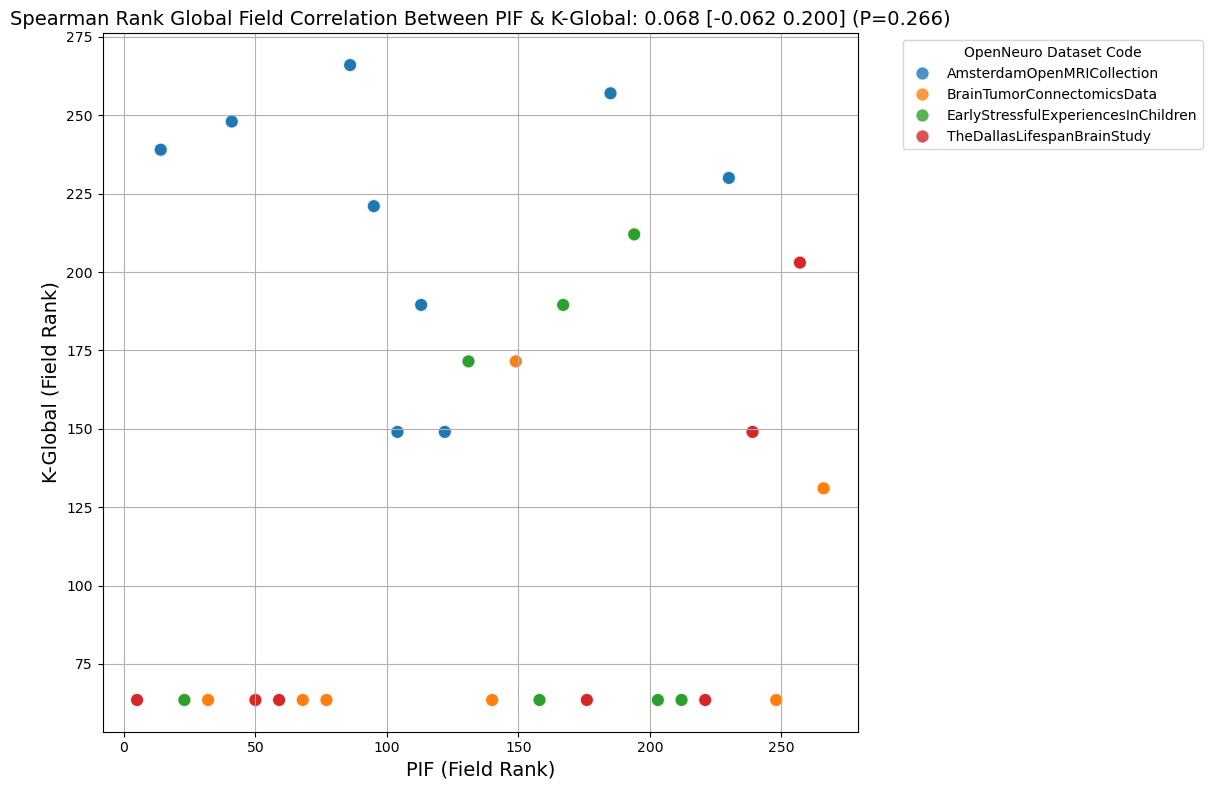

In [11]:
result_k_global = result_k_global.rename(columns={"Column": "column_name"})


merged_result = pd.merge(
    result_k_global,
    result_pif_fields,
    on=["column_name", "folder_name"],
    how="inner"
)
merged_result
merged_result['folder_name'] = merged_result['folder_name'].str.replace('data_', '', regex=False)



merged_result['PIF_rank_field'] = merged_result['sum_score'].rank()
merged_result['k_field_rank'] = merged_result['Normalized Difference'].rank()
spearman_corr_1, p_value_1 = spearmanr(merged_result['Normalized Difference'], merged_result['sum_score'])

# Bootstrap 95% CI
import numpy as np
np.random.seed(42)
n_bootstrap = 1000
bootstrap_corrs = []
for _ in range(n_bootstrap):
    indices = np.random.choice(len(merged_result), size=len(merged_result), replace=True)
    boot_sample = merged_result.iloc[indices]
    boot_corr, _ = spearmanr(boot_sample['Normalized Difference'], boot_sample['sum_score'])
    bootstrap_corrs.append(boot_corr)
ci_lower = np.percentile(bootstrap_corrs, 2.5)
ci_upper = np.percentile(bootstrap_corrs, 97.5)

print(f"Global Spearman Correlation: {spearman_corr_1:.3f} [95% CI: {ci_lower:.3f}, {ci_upper:.3f}], P-value: {p_value_1:.3f}")
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=merged_result,
    x='PIF_rank_field',
    y='k_field_rank',
    hue='folder_name',
    palette='tab10',
    s=90,
    alpha=0.8,
)
plt.grid(True)
plt.title(f"Spearman Rank Global Field Correlation Between PIF & K-Global: {spearman_corr_1:.3f} [{ci_lower:.3f} {ci_upper:.3f}] (P={p_value_1:.3f})", fontsize=14)
plt.xlabel('PIF (Field Rank)', fontsize=14)
plt.ylabel('K-Global (Field Rank)', fontsize=14)
plt.legend(title='OpenNeuro Dataset Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('spearman_rank_correlation_plot_pif_k_global_field.png', dpi=300)
plt.show()

Export as combined figure of all three correlations.

Combined figure saved as '/indirect/users/cyrilpernet/Downloads/OpenNeuro_MetaPrivAssessment/correlations.png'


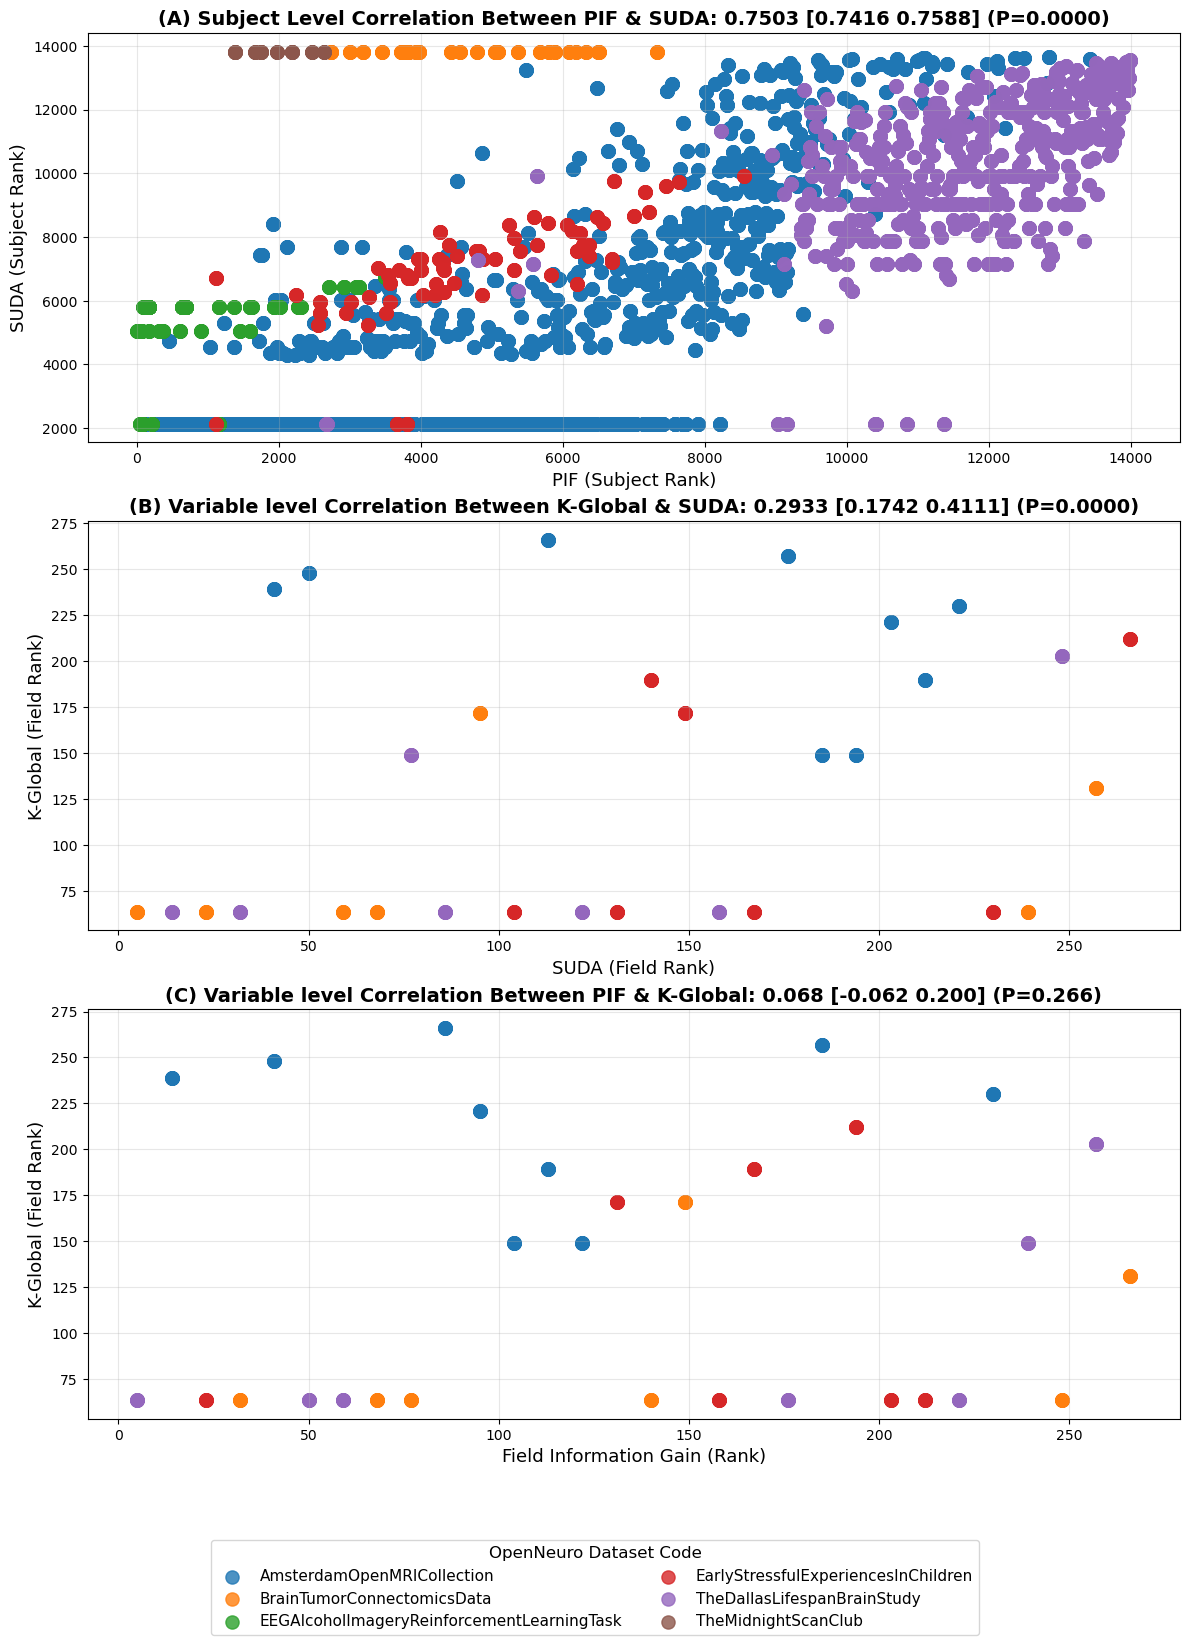

In [ ]:
# Create combined figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 16))

# Prepare data for all three plots - ensure we use the correct data collection
# Re-collect the row data if needed to ensure proper structure
def get_row_data():
    """Helper to ensure we have properly formatted row data"""
    base_dir = os.getcwd()
    
    # Collect PIF data
    pif_data = []
    suda_data = []
    
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            file_path = os.path.join(root, file)
            parent_dir = os.path.dirname(file_path)
            folder_name = os.path.basename(os.path.dirname(parent_dir))
            
            if file.lower().startswith('pif') and file.lower().endswith('.csv'):
                try:
                    df = pd.read_csv(file_path)
                    if 'Unnamed: 0' in df.columns and 'RIG' in df.columns:
                        temp_df = df[['RIG']].copy()
                        temp_df['original_index'] = df['Unnamed: 0']
                        temp_df['folder_name'] = folder_name
                        pif_data.append(temp_df)
                except Exception as e:
                    pass
            elif file.lower().startswith('suda') and file.lower().endswith('.csv'):
                try:
                    df = pd.read_csv(file_path)
                    if 'dis-score' in df.columns:
                        temp_df = df[['dis-score']].copy()
                        temp_df['original_index'] = df.index
                        temp_df['folder_name'] = folder_name
                        suda_data.append(temp_df)
                except Exception as e:
                    pass
    
    pif_df = pd.concat(pif_data, ignore_index=True) if pif_data else pd.DataFrame()
    suda_df = pd.concat(suda_data, ignore_index=True) if suda_data else pd.DataFrame()
    
    return pif_df, suda_df

# Get fresh row data
pif_rows, suda_rows = get_row_data()

# Plot 1: PIF & SUDA (rows)
if not pif_rows.empty and not suda_rows.empty:
    merged_rows = pd.merge(pif_rows, suda_rows, on=['original_index', 'folder_name'], suffixes=('_pif', '_suda'))
    merged_rows['RIG_rank'] = merged_rows['RIG'].rank()
    merged_rows['dis_score_rank'] = merged_rows['dis-score'].rank()
    spearman_corr_rows, p_value_rows = spearmanr(merged_rows['RIG'], merged_rows['dis-score'])
    
    # Bootstrap 95% CI for rows
    import numpy as np
    np.random.seed(42)
    n_bootstrap = 1000
    bootstrap_corrs_rows = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(merged_rows), size=len(merged_rows), replace=True)
        boot_sample = merged_rows.iloc[indices]
        boot_corr, _ = spearmanr(boot_sample['RIG'], boot_sample['dis-score'])
        bootstrap_corrs_rows.append(boot_corr)
    ci_lower_rows = np.percentile(bootstrap_corrs_rows, 2.5)
    ci_upper_rows = np.percentile(bootstrap_corrs_rows, 97.5)
else:
    merged_rows = pd.DataFrame()
    spearman_corr_rows, p_value_rows = 0, 1
    ci_lower_rows, ci_upper_rows = 0, 0

# Plot 2: K-Global & SUDA (fields)
result_k_global_temp = result_k_global.copy()
result_suda_temp = result_suda_fields.copy()
merged_k_suda = pd.merge(
    result_k_global_temp,
    result_suda_temp,
    left_on=["column_name", "folder_name"],
    right_on=["column_name", "folder_name"],
)
merged_k_suda['folder_name'] = merged_k_suda['folder_name'].str.replace('data_', '', regex=False)
merged_k_suda['k_global_rank'] = merged_k_suda['Normalized Difference'].rank()
merged_k_suda['suda_field_rank'] = merged_k_suda['contribution'].rank()
spearman_corr_k_suda, p_value_k_suda = spearmanr(merged_k_suda['Normalized Difference'], merged_k_suda['contribution'])

# Bootstrap 95% CI for K-Global & SUDA
import numpy as np
np.random.seed(42)
n_bootstrap = 1000
bootstrap_corrs_k_suda = []
for _ in range(n_bootstrap):
    indices = np.random.choice(len(merged_k_suda), size=len(merged_k_suda), replace=True)
    boot_sample = merged_k_suda.iloc[indices]
    boot_corr, _ = spearmanr(boot_sample['Normalized Difference'], boot_sample['contribution'])
    bootstrap_corrs_k_suda.append(boot_corr)
ci_lower_k_suda = np.percentile(bootstrap_corrs_k_suda, 2.5)
ci_upper_k_suda = np.percentile(bootstrap_corrs_k_suda, 97.5)

# Plot 3: PIF & K-Global (fields)
merged_pif_k = merged_result.copy()
spearman_corr_pif_k, p_value_pif_k = spearmanr(merged_pif_k['Normalized Difference'], merged_pif_k['sum_score'])

# Bootstrap 95% CI for PIF & K-Global
import numpy as np
np.random.seed(42)
n_bootstrap = 1000
bootstrap_corrs_pif_k = []
for _ in range(n_bootstrap):
    indices = np.random.choice(len(merged_pif_k), size=len(merged_pif_k), replace=True)
    boot_sample = merged_pif_k.iloc[indices]
    boot_corr, _ = spearmanr(boot_sample['Normalized Difference'], boot_sample['sum_score'])
    bootstrap_corrs_pif_k.append(boot_corr)
ci_lower_pif_k = np.percentile(bootstrap_corrs_pif_k, 2.5)
ci_upper_pif_k = np.percentile(bootstrap_corrs_pif_k, 97.5)

# Get unique folder names and create consistent color mapping
all_folders = pd.concat([
    merged_rows['folder_name'] if not merged_rows.empty else pd.Series(dtype=str),
    merged_k_suda['folder_name'],
    merged_pif_k['folder_name']
]).unique()
palette = sns.color_palette('tab10', n_colors=len(all_folders))
color_map = {folder: palette[i] for i, folder in enumerate(sorted(all_folders))}

# Plot 1: PIF & SUDA (Subject Rank)
if not merged_rows.empty:
    for folder in merged_rows['folder_name'].unique():
        subset = merged_rows[merged_rows['folder_name'] == folder]
        axes[0].scatter(subset['RIG_rank'], subset['dis_score_rank'], 
                       color=color_map[folder], s=90, alpha=0.8, label=folder)
axes[0].grid(True, alpha=0.3)
axes[0].set_title(f"(A) Subject Level Correlation Between PIF & SUDA: {spearman_corr_rows:.4f} [{ci_lower_rows:.4f} {ci_upper_rows:.4f}] (P={p_value_rows:.4f})", 
                 fontsize=14, fontweight='bold')
axes[0].set_xlabel('PIF (Subject Rank)', fontsize=13)
axes[0].set_ylabel('SUDA (Subject Rank)', fontsize=13)

# Plot 2: K-Global & SUDA (Field Rank)
for folder in merged_k_suda['folder_name'].unique():
    subset = merged_k_suda[merged_k_suda['folder_name'] == folder]
    axes[1].scatter(subset['suda_field_rank'], subset['k_global_rank'], 
                   color=color_map[folder], s=90, alpha=0.8, label=folder)
axes[1].grid(True, alpha=0.3)
axes[1].set_title(f"(B) Variable level Correlation Between K-Global & SUDA: {spearman_corr_k_suda:.4f} [{ci_lower_k_suda:.4f} {ci_upper_k_suda:.4f}] (P={p_value_k_suda:.4f})", 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('SUDA (Field Rank)', fontsize=13)
axes[1].set_ylabel('K-Global (Field Rank)', fontsize=13)

# Plot 3: PIF & K-Global (Field Rank)
for folder in merged_pif_k['folder_name'].unique():
    subset = merged_pif_k[merged_pif_k['folder_name'] == folder]
    axes[2].scatter(subset['PIF_rank_field'], subset['k_field_rank'], 
                   color=color_map[folder], s=90, alpha=0.8, label=folder)
axes[2].grid(True, alpha=0.3)
axes[2].set_title(f"(C) Variable level Correlation Between PIF & K-Global: {spearman_corr_pif_k:.3f} [{ci_lower_pif_k:.3f} {ci_upper_pif_k:.3f}] (P={p_value_pif_k:.3f})", 
                 fontsize=14, fontweight='bold')
axes[2].set_xlabel('Field Information Gain (Rank)', fontsize=13)
axes[2].set_ylabel('K-Global (Field Rank)', fontsize=13)

# Create single legend at the bottom with 2 columns
handles, labels = axes[0].get_legend_handles_labels()
# Sort by label name for consistent ordering
if handles:
    sorted_pairs = sorted(zip(labels, handles))
    labels_sorted, handles_sorted = zip(*sorted_pairs)
    fig.legend(handles_sorted, labels_sorted, 
              title='OpenNeuro Dataset Code', 
              loc='lower center', 
              bbox_to_anchor=(0.5, -0.03),
              ncol=2,
              frameon=True,
              fontsize=11,
              title_fontsize=12)

# Adjust layout to make room for legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.11)

# Save high-quality figure - save in the same directory as the notebook
import os
from pathlib import Path

# Get the directory where this notebook is located
notebook_dir = Path().cwd()
output_path = notebook_dir / 'correlations.png'

# Save the figure before showing it
plt.savefig(str(output_path), dpi=300, bbox_inches='tight', facecolor='white')
print(f"Combined figure saved as '{output_path}'")

# Verify the file was created
if output_path.exists():
    file_size = output_path.stat().st_size / 1024  # Size in KB
    print(f"✓ File successfully created: {file_size:.1f} KB")
else:
    print("✗ Warning: File was not created!")

plt.show()
